In [1]:
from __future__ import division
import pandas as pd

In [2]:
import cytoolz
from imret.query import Annotation
from imret.dataset import Dataset
from imret.color import ColorPalette

In [3]:
db = Dataset('../data/datasets/', 'test', '../data/images/')
# qa = Annotation('../data/query/test_anno/')
qa = Annotation('../data/corrected_test_anno/')

In [4]:
scores = {}

In [11]:
df = pd.read_csv('../tasks/scene_index.csv')
df.head()

,image,scene,est,preposition,object1,object2,score
0,a_airlock_airlock_000212.jpg,indoor,indoor,above,chair,floor,0.503983
1,a_airlock_airlock_000212.jpg,indoor,indoor,under,chair,table,0.721167
2,a_airlock_airlock_000212.jpg,indoor,indoor,in,chair,wall,0.287512
3,a_airlock_airlock_000212.jpg,indoor,indoor,under,floor,chair,0.608941
4,a_airlock_airlock_000212.jpg,indoor,indoor,under,floor,table,0.605973


In [12]:
query = qa.db.keys()[6]
noun1, preposition, noun2 = query.split('-')
print query

plant-behind-rocks


In [13]:
# noun1 = noun1.replace('flowers', 'flower').replace('rocks', 'rock').replace('cars', 'car')
# noun2 = noun2.replace('flowers', 'flower').replace('rocks', 'rock').replace('cars', 'car')
# preposition = preposition.replace('_', ' ')
noun1 = 'grass'
noun2 = 'rock'
preposition = 'behind'

scene = None
if noun1 in inv_labels['indoor'] and noun2 in inv_labels['indoor']:
    scene = 'indoor'
elif noun1 in inv_labels['outdoor'] and noun2 in inv_labels['outdoor']:
    scene = 'outdoor'
    
print "scene", scene
    
valid = df[(df.object1 == noun1) & 
           (df.object2 == noun2) &
           (df.preposition == preposition) &
           (df.est == scene)][['image', 'score', 'preposition']]

NameError: name 'inv_labels' is not defined

In [14]:
valid.drop_duplicates('image', inplace=True)
retrieved, relevance = valid['image'].values, valid['score'].values
print len(retrieved), set(valid.preposition)

NameError: name 'valid' is not defined

In [3828]:
tp = len(set(qa.db[query]) & set(retrieved))
fp = len(retrieved) - tp
tn = len(set(db.images).difference(set(retrieved)).difference(set(qa.db[query])))
fn = len(qa.db[query]) - tp

In [3829]:
print tp, fp, tn, fn, len(qa.db[query])

1 56 4255 5 6


In [3830]:
import numpy as np

def apk(actual, predicted, k=4317):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        
    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [3831]:
def c_apk(expected, predicted, k=4317):
    retrieved = np.array([ret in expected for ret in predicted[:k]]).astype(np.int32)
    if retrieved.sum() == 0:
        return 0.0
    
    scores = np.arange(len(retrieved)) + 1
    valids = np.where(retrieved > 0)
    return np.sum(np.cumsum(retrieved[valids]) / scores[valids].astype(np.float32)) / float(min(len(expected), k))


In [3832]:
print apk(qa.db[query], retrieved, k=5000)
print c_apk(qa.db[query], retrieved, k=5000)
scores[query] = c_apk(qa.db[query], retrieved, k=5000)

0.00396825396825
0.00396825396825


In [3833]:
print np.mean([sc for sc in scores.values() if sc > 0])
print np.mean(scores.values())

0.0951124235035
0.0839227266207


In [3834]:
import os

In [3835]:
freqs = {}
def filter_by_area(retrieved, noun1, noun2, scene, area1=10000, area2=10000):
    for imname in retrieved:
        name = os.path.join('../data/scene/output-seg/{scene}-bw/'.format(scene=scene), imname.replace('.jpg', '.png'))
        freq = freqs.get(name, None)
        
        if freq is None:
            img = cv2.imread(name, 0)
            if img is None:
                continue
            freq = cytoolz.frequencies(img.flatten())
            
        freqs[name] = freq
        
        if freq[inv_labels[scene][noun1]] > area1 and freq[inv_labels[scene][noun2]] > area2:
            yield imname

In [3836]:
retrieved_filtered = list(filter_by_area(retrieved, noun1, noun2, scene=scene, area1=1000, area2=1000))
print(len(retrieved_filtered))

32


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [17]:

with open("../data/scene/outdoor/palette.txt", "r") as fp:
    colors = np.array([map(int, line.strip().split()) for line in fp.readlines()])
    
labels = {}
with open('../data/scene/outdoor/labels.txt', 'r') as fp:
    labels['outdoor'] = dict([line.replace('#', '').replace(':', '').strip().split() for line in fp.readlines()])
    
with open('../data/scene/indoor/labels.txt', 'r') as fp:
    labels['indoor'] = dict([line.replace('#', '').replace(':', '').strip().split() for line in fp.readlines()])
    
    
labels['outdoor'] = {int(k): v for k, v in labels['outdoor'].items()}
labels['indoor'] = {int(k): v for k, v in labels['indoor'].items()}


inv_labels = {}
inv_labels['outdoor'] ={v: k for k, v in labels['outdoor'].items()}
inv_labels['indoor'] ={v: k for k, v in labels['indoor'].items()}

NameError: name 'np' is not defined

In [3846]:
db_extend = [
#     '',
    'b_badlands_bad_lands_000011.jpg',
    'c_castle_382004_7.jpg',
    'd_desert_opencountry_natu524.jpg'
]

print len(list(set(qa.db[query] + db_extend))), len(retrieved_filtered)
print apk(list(set(qa.db[query] + db_extend)), retrieved_filtered)
print c_apk(list(set(qa.db[query] + db_extend)), retrieved_filtered)

9 32
0.352657004831
0.352657004831


In [3840]:
begin = 0
diffs = [rt for rt in retrieved_filtered if not rt in qa.db[query]]
print "{}/{}".format(begin, len(diffs))
print "\n".join(sorted(diffs[begin:begin+3]))

0/31
b_badlands_bad_lands_000011.jpg
c_castle_382004_7.jpg
d_desert_opencountry_natu524.jpg


grass area 3002
rock area 4289
../data/images/d_desert_opencountry_natu524.jpg


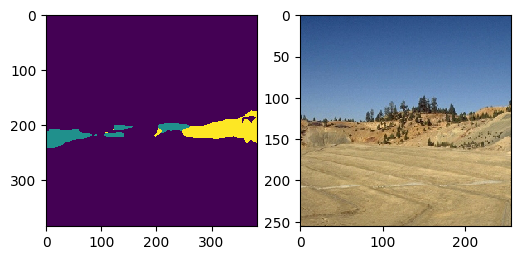

In [3845]:
name = 'd_desert_opencountry_natu524'

img = cv2.imread('../data/scene/output-seg/{}-bw/{}.png'.format(scene, name), 0)
freq =  cytoolz.frequencies(img.flatten())
print "{} area {}".format(noun1, freq[inv_labels[scene][noun1]])
print "{} area {}".format(noun2, freq[inv_labels[scene][noun2]])

template = np.zeros(img.shape, dtype=np.uint8)
x, y = np.where(img == inv_labels[scene][noun1]); template[x, y] = 128
x, y = np.where(img == inv_labels[scene][noun2]); template[x, y] = 255

plt.subplot(121); plt.imshow(template)
plt.subplot(122); plt.imshow(cv2.imread('../data/images/{}.jpg'.format(name))[:, :, (2, 1, 0)])
print '../data/images/{}.jpg'.format(name)

In [3822]:
# qa_ = Annotation('../data/query/test_anno/')
qa_ = Annotation('../data/corrected_test_anno/')

images_ = set(df.image)
invs = []
areas = {'water': 10000, 'sky': 10000, 'table': 10000, 'wall': 10000}

total = []
for nn, query in enumerate(qa_.db.keys()):
    if query == 'plant-behind-rocks':
        noun1 = 'grass'
        noun2 = 'rock'
        preposition = 'behind'
    else:
        noun1, preposition, noun2 = query.split('-')
        noun1 = noun1.replace('flowers', 'flower').replace('rocks', 'rock').replace('cars', 'car')
        noun2 = noun2.replace('flowers', 'flower').replace('rocks', 'rock').replace('cars', 'car')
        preposition = preposition.replace('_', ' ')

    scene = None
    if noun1 in inv_labels['indoor'] and noun2 in inv_labels['indoor']:
        scene = 'indoor'
    elif noun1 in inv_labels['outdoor'] and noun2 in inv_labels['outdoor']:
        scene = 'outdoor'
    
    if noun1 != noun2:
        if preposition in ['in front of', 'across from', 'left of', 'right of', 'inside of']:
            valid = df[(df.object1 == noun1) & 
                       (df.object2 == noun2) &
                       (df.est == scene)][['image', 'score']]
        else:
            valid = df[(df.object1 == noun1) & 
                       (df.object2 == noun2) &
                       (df.preposition == preposition) &
                       (df.est == scene)][['image', 'score']]
    else:
        valid = df[(df.object1 == noun1) & (df.est == scene)][['image', 'score']]
    
    valid.drop_duplicates('image', inplace=True)
    retrieved, relevance = valid['image'].values, valid['score'].values
    
    
    retrieved_filtered = list(filter_by_area(retrieved, noun1, noun2, 
                                             scene=scene, area1=areas.get(noun1, 0), area2=areas.get(noun2, 0)))
    ground_truth = [img for img in qa_.db[query] if img in images_]
    if not ground_truth or scene is None:
#         print "{}: {:50s} \t {:8s} AP: {}".format(nn, query, scene, 'invalid')
        if scene is None:
            invs.append(query)
        continue
        
    score = c_apk(ground_truth, retrieved_filtered)
    print "{}: {:50s} \t {:8s} AP: {:.4f}".format(nn, query, scene, score)
    total.append(score)
    
print "mAP: {:.6f}".format(np.mean(total))

0: water-under-sky                                    	 outdoor  AP: 0.7191
1: car-across_from-van                                	 outdoor  AP: 0.1133
2: chair-left_of-wall                                 	 indoor   AP: 0.0993
4: table-in_front_of-wall                             	 indoor   AP: 0.1775
6: plant-behind-rocks                                 	 outdoor  AP: 0.0054
7: flowers-inside_of-vase                             	 indoor   AP: 0.0414
8: mirror-in-wall                                     	 indoor   AP: 0.2580
13: rocks-under-sky                                    	 outdoor  AP: 0.2215
14: balcony-above-balcony                              	 outdoor  AP: 0.0192
16: road-below-building                                	 outdoor  AP: 0.2084
18: window-in-wall                                     	 indoor   AP: 0.3473
19: window-under-window                                	 indoor   AP: 0.0006
20: airplane-under-sky                                 	 outdoor  AP: 0.3641
22: ro

In [3816]:
cp = ColorPalette('../data/query/name_conversion.csv')
def _filter_by_area(retrieved, noun1, noun2, scene, area1=10000, area2=10000):
    for imname in retrieved:
        name = os.path.join('../data/segmented/'.format(scene=scene), imname.replace('.jpg', '.png'))
        freq = _freqs.get(name, None)
        
        if freq is None:
            img = cv2.imread(name, 0)
            if img is None:
                continue
            freq = {cp.get_name(k): v for k, v in cytoolz.frequencies(img.flatten()).items()}
            
        _freqs[name] = freq
        
        if freq.get(noun1, 0) > area1 and freq.get(noun2, 0) > area2:
            yield imname

total2 = []
for nn, query in enumerate(invs):
    noun1, preposition, noun2 = query.split('-')
    noun1 = noun1.replace('flowers', 'flower').replace('rocks', 'rock').replace('cars', 'car')
    noun2 = noun2.replace('flowers', 'flower').replace('rocks', 'rock').replace('cars', 'car')
    preposition = preposition.replace('_', ' ')
    
    
    if preposition in ['in front of', 'across from', 'left of', 'right of', 'inside of']:
        valid = df2[(df2.object1 == noun1) & 
                    (df2.object2 == noun2)][['image', 'score']]
    else:
        valid = df2[(df2.object1 == noun1) & 
                   (df2.object2 == noun2) &
                   (df2.preposition == preposition)][['image', 'score']]
    
    valid.drop_duplicates('image', inplace=True)
    retrieved, relevance = valid['image'].values, valid['score'].values
    
    
    retrieved_filtered = list(_filter_by_area(retrieved, noun1, noun2, 
                                              scene=scene, area1=areas.get(noun1, 0), area2=areas.get(noun2, 0)))
    ground_truth = [img for img in qa_.db[query] if img in images_]
    if not ground_truth or scene is None:
        print "{}: {:50s} \t {:8s} AP: {}".format(nn, query, scene, 'invalid')
        if scene is None:
            invs.append(query)
        continue
        
    score = c_apk(ground_truth, retrieved_filtered)
    print "{}: {:50s} \t {:8s} AP: {:.4f}".format(nn, query, scene, score)
    total2.append(score)
    
print "mAP: {:.6f}".format(np.mean(total2))

0: bench-right_of-wall                                	 indoor   AP: 0.0134
1: building-behind-wall                               	 indoor   AP: 0.0258
2: plant-behind-rocks                                 	 indoor   AP: 0.0139
3: gate-in-wall                                       	 indoor   AP: 0.0202
4: bench-in_front_of-wall                             	 indoor   AP: 0.0311
5: grass-below-window                                 	 indoor   AP: 0.1533
6: ground-under-sky                                   	 indoor   AP: 0.1376
7: ground-behind-road                                 	 indoor   AP: 0.0000
8: chair-right_of-tree                                	 indoor   AP: 0.0199
9: floor-under-sky                                    	 indoor   AP: 0.0196
10: sign-right_of-wall                                 	 indoor   AP: 0.1045
11: building-on-ground                                 	 indoor   AP: 0.0523
12: door-behind-wall                                   	 indoor   AP: 0.0079
13: bench

In [3850]:
total[4] = 0.352657004831
np.mean(total), np.mean(total + total2), len(total), len(total2)

(0.15846753918266696, 0.12782559737532845, 38, 14)

In [3810]:
set(df2[(df2.object1 == 'ground') & (df2.object2 == 'road') & (df2.preposition == 'behind')].image)

{'a_access_road_access_road_000627.jpg',
 'a_aircraft_carrier_aircraft_carrier_1_b.jpg',
 'a_airport_p1010188.jpg',
 'a_alleyway_alleyway_000182.jpg',
 'a_alleyway_alleyway_000760.jpg',
 'a_amphitheater_outdoor_100_1499.jpg',
 'a_amphitheater_outdoor_133946_l.jpg',
 'a_archipelago_archipelago02.jpg',
 'a_arena_arena_000006.jpg',
 'a_arena_arena_000401.jpg',
 'a_army_hut_army_hut_000017.jpg',
 'a_assembly_plant_assembly_plant_000003.jpg',
 'a_athletic_field_athletic_field_000222.jpg',
 'a_athletic_field_athletic_field_000398.jpg',
 'a_atrium_home_google_24_atrium__home_2.jpg',
 'b_backdoor_outdoor_back_entrance_000268.jpg',
 'b_backwater_Kerala_backwater.jpg',
 'b_backwater_backwater_000478.jpg',
 'b_badminton_court_indoor_07_covered_badminton_court_photo.jpg',
 'b_baptistry_indoor_baptistery_000625.jpg',
 'b_bar_terrace_terracebar_b.jpg',
 'b_baseball_field_ballpark_000009.jpg',
 'b_basketball_court_outdoor_basketball_court_000498.jpg',
 'b_beach_coast_bea2.jpg',
 'b_beach_coast_osun52

In [3789]:
df2 = pd.read_csv('../data/preposition/index.csv')

In [3793]:
_freqs = {}

In [3821]:
labels['outdoor']

{0: '__background__',
 1: 'airplane',
 2: 'balcony',
 3: 'bench',
 4: 'building',
 5: 'car',
 6: 'door',
 7: 'fence',
 8: 'gate',
 9: 'grass',
 10: 'path',
 11: 'road',
 12: 'rock',
 13: 'sign',
 14: 'sky',
 15: 'streetlight',
 16: 'tree',
 17: 'van',
 18: 'water'}